    Projemizde Kalp Rahatsızlığı için inceleme yapıyoruz.
Bu incelemede insanların kilolarına göre Sistolik Kan Basıncı ve Diyastolik Kan Basıncı nasıl değişim göstermektedir bunu incelemekteyiz.

Alan bilgisi :

Sistolik Kan Basıncı: Sistolik kan basıncı, kalbin en yüksek basıncını temsil eder ve kalp kasının kasıldığı sırada arterlerde oluşan basıncı ölçer.(ap_hi)
Sağlıklı yetişkinlerde, genellikle 90 ila 120 mm Hg arasında olmalıdır.120 ila 129 mm Hg arasındaki değerler normal olarak kabul edilirken, 130 ila 139 mm Hg arasındaki değerler yüksek normal (prehypertension) olarak kabul edilir

Diastolik Kan Basıncı: Diastolik kan basıncı, kalbin en düşük basıncını temsil eder ve kalp kasının gevşediği sırada arterlerde oluşan basıncı ölçer.(ap_lo)
Sağlıklı yetişkinlerde, genellikle 60 ila 80 mm Hg arasında olmalıdır.80 ila 89 mm Hg arasındaki değerler yüksek normal (prehypertension) olarak kabul edilir.

In [48]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy.stats import norm
from scipy.stats import chi2

In [49]:
df = pd.read_excel(r'C:\Users\Can\Desktop\Project of Ist 2\cardio_train.xlsx')

print(df)

          id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0          0  18393       2     168    62.0    110     80            1     1   
1          1  20228       1     156    85.0    140     90            3     1   
2          2  18857       1     165    64.0    130     70            3     1   
3          3  17623       2     169    82.0    150    100            1     1   
4          4  17474       1     156    56.0    100     60            1     1   
...      ...    ...     ...     ...     ...    ...    ...          ...   ...   
69995  99993  19240       2     168    76.0    120     80            1     1   
69996  99995  22601       1     158   126.0    140     90            2     2   
69997  99996  19066       2     183   105.0    180     90            3     1   
69998  99998  22431       1     163    72.0    135     80            1     2   
69999  99999  20540       1     170    72.0    120     80            2     1   

       smoke  alco  active  cardio  
0 

Aralarından ilgilendiğim değişkenleri seçerim.

In [50]:
selected_population_variables = df[["id", "weight", "ap_hi", "ap_lo"]]
print(selected_population_variables)

          id  weight  ap_hi  ap_lo
0          0    62.0    110     80
1          1    85.0    140     90
2          2    64.0    130     70
3          3    82.0    150    100
4          4    56.0    100     60
...      ...     ...    ...    ...
69995  99993    76.0    120     80
69996  99995   126.0    140     90
69997  99996   105.0    180     90
69998  99998    72.0    135     80
69999  99999    72.0    120     80

[70000 rows x 4 columns]


Kitlemizde herhangi bir inceleme yapamıyorum çünkü çok fazla kirli veri var bunları da düzenlemek istiyorum.

Alan bilgisini kullanarak;

Sistolik kan basıncı için: (75, 175)

Diastolik kan basıncı için: (60, 120)

Kilo için: (0, 170)

Aralığının dışındaki olan değerler var mı hesaplayıp bu aralıkta olan bir değere atayalım.

In [51]:
def check_outlier(data, max_lim=0, min_lim=0, name_data='name of data'):
    outlier_count = 0
    for inner in data.values:
        if (inner > max_lim or inner < min_lim):
            outlier_count += 1
        else:
            pass
    if outlier_count == 0:
        print(f'{name_data} için Aykiri Değer Yoktur.')
    else:
        print(f'{name_data} için Aykiri Değer ya da Değerler vardir.')
        print(f'{name_data} için Aykiri Değer sayisi: {outlier_count}')
        
check_outlier(selected_population_variables['ap_hi'],
              max_lim=175, min_lim=75, name_data='Sistolik')
check_outlier(selected_population_variables['ap_lo'],
              max_lim=120, min_lim=60, name_data='Diyalostik')
check_outlier(selected_population_variables['weight'],
              max_lim=175, min_lim=0, name_data='Kilo')

Sistolik için Aykiri Değer ya da Değerler vardir.
Sistolik için Aykiri Değer sayisi: 1283
Diyalostik için Aykiri Değer ya da Değerler vardir.
Diyalostik için Aykiri Değer sayisi: 1231
Kilo için Aykiri Değer ya da Değerler vardir.
Kilo için Aykiri Değer sayisi: 12


Bulduğumuz Aykırı Değerleri Aralıkta bir değere atayalım

In [52]:
selected_population_variables.loc[(selected_population_variables['ap_lo'] > 120) | (
    selected_population_variables['ap_lo'] < 60), 'ap_lo'] = 80

selected_population_variables.loc[(selected_population_variables['ap_hi'] > 170) | (
    selected_population_variables['ap_hi'] < 75), 'ap_hi'] = 105

selected_population_variables.loc[selected_population_variables['weight']
                                  > 170, 'weight'] = 85

Test Edelim

In [53]:
check_outlier(selected_population_variables['ap_hi'],
              max_lim=175, min_lim=75, name_data='Sistolik')
check_outlier(selected_population_variables['ap_lo'],
              max_lim=120, min_lim=60, name_data='Diyalostik')
check_outlier(selected_population_variables['weight'],
              max_lim=175, min_lim=0, name_data='Kilo')

Sistolik için Aykiri Değer Yoktur.
Diyalostik için Aykiri Değer Yoktur.
Kilo için Aykiri Değer Yoktur.


70.000 tane veri olduğu için bunları temsil edecek bir örnekleme ihtiyacım var, öncelikle örneklem büyüklüğünü hesaplayalım.

In [54]:
def sample_size_cal(pop):
    """
        Info: This function calculate the size of population.
        Parameter: Populaiton
    """
    # CONFIDANCE_LEVEL = 0.95
    variance_pop = pop.var()
    pop_size = len(pop)
    DEVIATION = 10
    Z_TABLE = 2
    P = 0.5
    Q = 1-P
    sample_size = ((pop_size)*(Z_TABLE**2)*(variance_pop)) / \
        ((DEVIATION**2)*(pop_size-1)+(Z_TABLE**2)*(variance_pop))
    rounded_sample_size = round(sample_size)
    return rounded_sample_size
print(sample_size_cal(df["ap_hi"]))

934


Örneklem büyüklüğünü hesapladık şimdi de örneklemimizi Sistematik Örnekleme Yöntemi ile seçelim

k = 70

In [55]:
pop_size = len(df)
sampleSize = 1000

sample_index = [i for i in range(0, pop_size, 70)]
missing_data = sampleSize - len(sample_index)

if missing_data > 0:
    missing_data = random.sample(range(pop_size), missing_data)
    sample_index.extend(missing_data)

sample = selected_population_variables.iloc[sample_index]

selected_sample_variables = sample[["id", "weight", "ap_hi", "ap_lo"]]

print(selected_sample_variables)

          id  weight  ap_hi  ap_lo
0          0    62.0    110     80
70        95    57.0    120     80
140      189    55.0    120     90
210      289    75.0    150    100
280      383    72.0    160     90
...      ...     ...    ...    ...
69650  99483    89.0    120     70
69720  99578    71.0    120     80
69790  99680    75.0    140     90
69860  99778    55.0    120     80
69930  99894    60.0    140    100

[1000 rows x 4 columns]


In [56]:
df_ap_lo = selected_sample_variables['ap_lo']
df_ap_hi = selected_sample_variables['ap_hi']
df_weight = selected_sample_variables['weight']

1000 kişilik bir örneklem çekmiş olduk, şimdi aykırı değerlerimizi inceleyelim.

In [57]:
def outler_detec(val, name='', level=0):
    """
        Info: sample mean +- level*sample standart deviation
    """
    formula_outlier_upper = val.mean() + (level * math.sqrt(val.var()))
    formula_outlier_lower = val.mean() - (level * math.sqrt(val.var()))
    formula_outlier = (formula_outlier_lower, formula_outlier_upper)
    print(f'{name} : {formula_outlier}')
    
    
outler_detec(selected_sample_variables['ap_lo'], name='Diastolic', level=3) 
outler_detec(selected_sample_variables['ap_hi'], name='Sistolic', level=3) 
outler_detec(selected_sample_variables['weight'], name='Weight', level=7) 

Diastolic : (53.82614400802488, 108.27585599197512)
Sistolic : (79.68829869734981, 170.8677013026502)
Weight : (-24.470731287554997, 171.136931287555)


Bu aralıklara göre kitlemizdeki verileri düzenlemiştik. Çektiğimiz örneklemde bir problem var mı? Kendi yazdığımız aykırı değer kontrol fonksiyonumuzdan inceleyelim.

In [58]:
check_outlier(df_ap_hi,
              max_lim=175, min_lim=75, name_data='Örneklemin Sistolik Kan Basinci')
check_outlier(df_ap_lo,
              max_lim=120, min_lim=60, name_data='Örneklemin Diyalostik Kan Basinci')
check_outlier(df_weight,
              max_lim=175, min_lim=0, name_data='Örneklemin Kilo değişkeni')

Örneklemin Sistolik Kan Basinci için Aykiri Değer Yoktur.
Örneklemin Diyalostik Kan Basinci için Aykiri Değer Yoktur.
Örneklemin Kilo değişkeni için Aykiri Değer Yoktur.


Verilerimiz için Istatistiksel Analizlerimizi yapalım.

In [59]:
def analyse_descriptive_statistic(param, param_name):
    """
        Info: This function basic analyse to data. Such as(mean, variance, median, quantiles, standart deviation)
        Parameters: param = Dataset, param_name = name of dataset 
    """
    param_mean = param.mean()
    param_var = param.var()
    param_median = param.median()
    # param_mode = param.mode()
    param_quantiles = param.quantile()
    param_standart_deviation = math.sqrt(param.var())
    print(f"""
          {param_name} mean is : {param_mean}
          {param_name} variance is : {param_var}
          {param_name} median is : {param_median}
          {param_name} quantiles is : {param_quantiles}
          {param_name} standart deviation is : {param_standart_deviation}""", sep="")


analyse_descriptive_statistic(df_weight, 'Weight')
analyse_descriptive_statistic(df_ap_hi, 'Systolic Blood Pressure')
analyse_descriptive_statistic(df_ap_lo, 'Diastolic Blood Pressure')


          Weight mean is : 73.3331
          Weight variance is : 195.21611050050046
          Weight median is : 71.0
          Weight quantiles is : 71.0
          Weight standart deviation is : 13.971975898222142

          Systolic Blood Pressure mean is : 125.278
          Systolic Blood Pressure variance is : 230.93565165165165
          Systolic Blood Pressure median is : 120.0
          Systolic Blood Pressure quantiles is : 120.0
          Systolic Blood Pressure standart deviation is : 15.196567100883398

          Diastolic Blood Pressure mean is : 81.051
          Diastolic Blood Pressure variance is : 82.35475375375376
          Diastolic Blood Pressure median is : 80.0
          Diastolic Blood Pressure quantiles is : 80.0
          Diastolic Blood Pressure standart deviation is : 9.07495199732504


Verilerimizi Gorsellestirelim

In [60]:
def visualization_data(data1, data2, graph):
    """
        Info: this function plot graphs
        x: data1
        y: data2
        graphs:
            graphs = 1 histogram
            graphs = 2 Trend
            graphs = 3 Curve
    """
    plt.xlabel = data1
    plt.ylabel = data2
    if graph == 1:
        plt.title('Graph Of Histogram')
        plt.hist(data1, bins=15, color="skyblue")
        plt.grid(True)
        plt.show()
    if graph == 2:
        plt.title('Graph Of Trend')
        sns.regplot(x=data1, y=data2, ci=None)
        plt.grid(True)
        plt.show()
    if graph == 3:
        plt.title('Graph Of Curve')
        plt.plot(data1, data2,
                 marker='o', color='green', linestyle='-')
        plt.grid(True)
        plt.show()
    else:
        pass

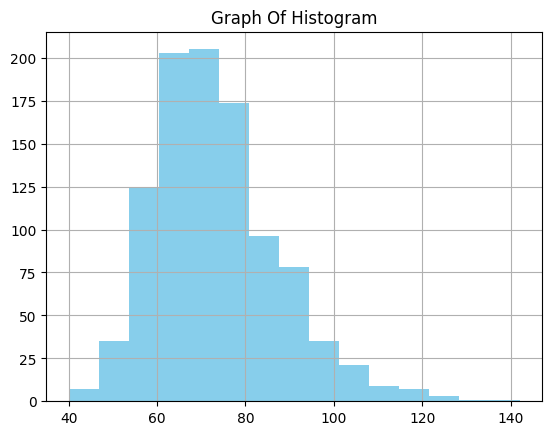

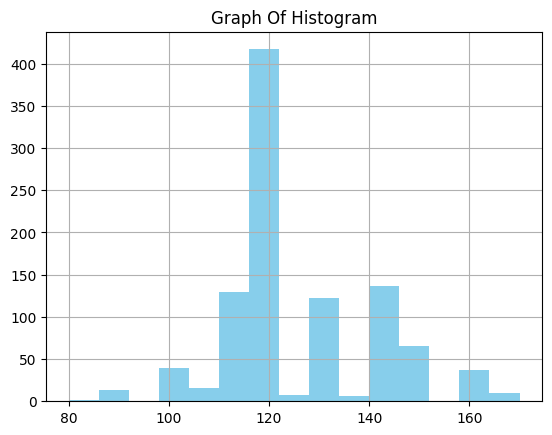

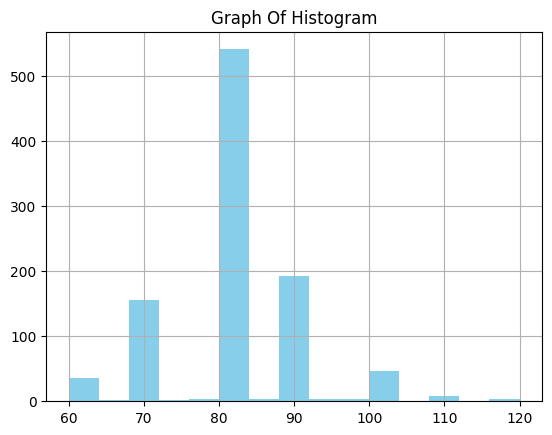

In [61]:
visualization_data(df_weight, df_weight, graph=1)
visualization_data(df_ap_hi, df_ap_hi, graph=1)
visualization_data(df_ap_lo, df_ap_lo, graph=1)

1. Grafik - Weight - Ağırlıklarımız Histogram Grafiğinden görüleceği üzere sağa çarpık
2. Grafik - Systolic Blood Pressure - Sistolik kan basıncı aynı şekilde sağa çarpık
3. Grafik - Diastolic Blood Pressure - Diyastolik kan basıncı da aynı şekilde sağa çarpık

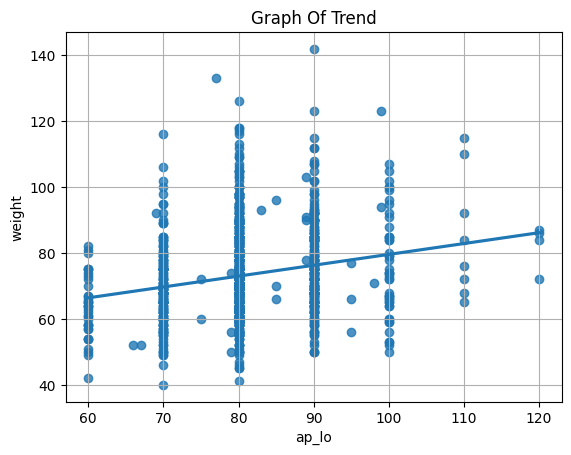

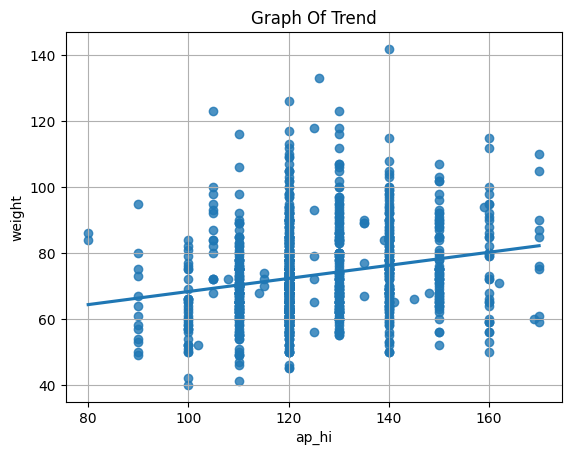

In [62]:
visualization_data(df_ap_lo, df_weight, graph=2)
visualization_data(df_ap_hi, df_weight, graph=2)

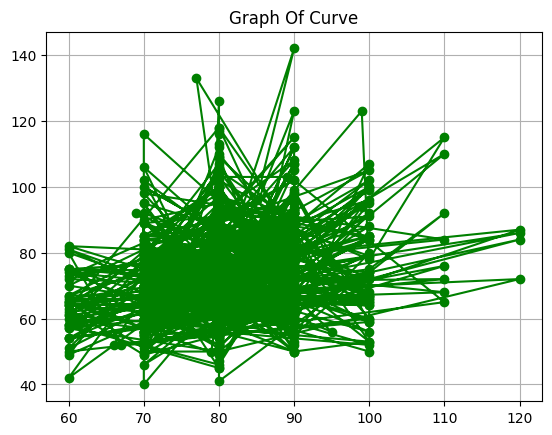

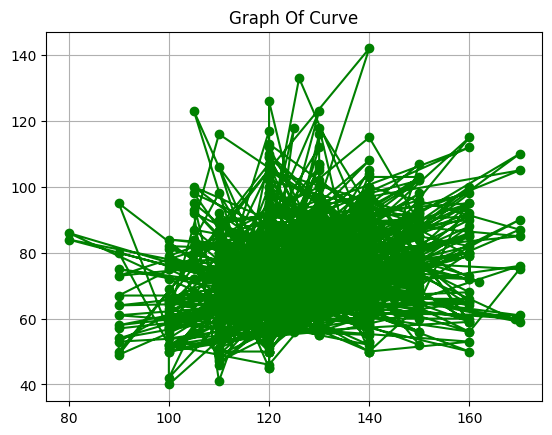

In [63]:
visualization_data(df_ap_lo, df_weight, graph=3)
visualization_data(df_ap_hi, df_weight, graph=3)

Ortalama için Güven Aralığı hesaplayalım

In [64]:
def confidence_interval_mean(param_sample, param_population):
    alpha = 0.05
    sample_size = len(param_sample)
    z_value = norm.ppf(1-(alpha/2))  # table score
    samp_mean = param_sample.mean()
    pop_var = param_population.var()
    pop_ss = math.sqrt(pop_var)
    low_limit = samp_mean - z_value * (pop_ss / math.sqrt(sample_size))
    upper_limit = samp_mean + z_value * (pop_ss / math.sqrt(sample_size))
    confidance_range = low_limit, upper_limit
    return confidance_range


print("Kilo değişkenimiz için aralğimiz: ", confidence_interval_mean(df_weight, selected_population_variables['weight']))
print('Örneklemin kitleyi temsil ettiği aralik bu araliktir, örneklemin kitleyi temsil etme olasiliği %95 tir.')
print("Sistolik kan basinci için için aralğimiz: ", confidence_interval_mean(df_ap_hi, selected_population_variables['ap_hi']))
print('Örneklemin kitleyi temsil ettiği aralik bu araliktir, örneklemin kitleyi temsil etme olasiliği %95 tir.')
print("Diyastolik kan basinci için aralğimiz: ", confidence_interval_mean(df_ap_lo, selected_population_variables['ap_lo']))
print('Örneklemin kitleyi temsil ettiği aralik bu araliktir, örneklemin kitleyi temsil etme olasiliği %95 tir.')

Kilo değişkenimiz için aralğimiz:  (72.44609914558464, 74.22010085441536)
Örneklemin kitleyi temsil ettiği aralik bu araliktir, örneklemin kitleyi temsil etme olasiliği %95 tir.
Sistolik kan basinci için için aralğimiz:  (124.31010739698488, 126.24589260301514)
Örneklemin kitleyi temsil ettiği aralik bu araliktir, örneklemin kitleyi temsil etme olasiliği %95 tir.
Diyastolik kan basinci için aralğimiz:  (80.4793628350032, 81.6226371649968)
Örneklemin kitleyi temsil ettiği aralik bu araliktir, örneklemin kitleyi temsil etme olasiliği %95 tir.


In [65]:
def confidence_interval_var(param_sample):
    alpha = 0.1
    n = len(param_sample)
    degree_of_freedom = n-1
    samp_var = param_sample.var()
    critical_value1 = chi2.ppf(1-(alpha/2), degree_of_freedom)
    critical_value2 = chi2.ppf(alpha/2, degree_of_freedom)
    low_limit = ((degree_of_freedom)*(samp_var))/(critical_value1)
    upper_limit = ((degree_of_freedom)*(samp_var))/(critical_value2)
    confidance_range = low_limit, upper_limit
    return confidance_range


print('Kilo için kitle varyans tahmin araliği: ',
      confidence_interval_var(df_weight))
print('Orneklimin Kitle varyansini tahmin etme araliğidir. %90 güven araliğinde tahmin yapilmiştir.')
print('Sistolik kan basinci için kitle varyans tahmin araliği: ',
      confidence_interval_var(df_ap_hi))
print('Orneklimin Kitle varyansini tahmin etme araliğidir. %90 güven araliğinde tahmin yapilmiştir.')
print('Diyastolik kan basinci için kitle varyans tahmin araliği: ',
      confidence_interval_var(df_ap_lo))
print('Orneklimin Kitle varyansini tahmin etme araliğidir. %90 güven araliğinde tahmin yapilmiştir.')

Kilo için kitle varyans tahmin araliği:  (181.64413855073906, 210.4622665573685)
Orneklimin Kitle varyansini tahmin etme araliğidir. %90 güven araliğinde tahmin yapilmiştir.
Sistolik kan basinci için kitle varyans tahmin araliği:  (214.88035694067517, 248.97146322042363)
Orneklimin Kitle varyansini tahmin etme araliğidir. %90 güven araliğinde tahmin yapilmiştir.
Diyastolik kan basinci için kitle varyans tahmin araliği:  (76.62922011306283, 88.78656629491925)
Orneklimin Kitle varyansini tahmin etme araliğidir. %90 güven araliğinde tahmin yapilmiştir.
